# Merge datasets and create a PostgreSQL database

In [45]:
import pandas as pd
import numpy as np
import re
from glob import glob
import matplotlib.pyplot as plt
import collections

In [2]:
# Dataframe with products from comments
curly_df = pd.read_csv('dataframe_with_products.csv')

#curly_df['products_used'].iloc[0]

"[('shea_moisture curl and shine shampoo', 'shampoo'), ('suave essentials conditioners', 'conditioner'), ('suave essentials conditioners', 'leave-in'), ('shea_moisture curl enhancing smoothie', 'cream'), ('suave essentials shampoo daily clarifying', 'clarifying shampoo')]"

In [3]:
# CSV with filepaths and labels
files = glob('image_urls_labels*.csv')

img_df = pd.DataFrame(columns=['file_path', 'class', 'pred'])

for f in files:
    df = pd.read_csv(f)
    
    img_df = img_df.append(df, sort=True)
    
img_df.drop(columns=['Unnamed: 0'], inplace=True)
#img_df.head()

,class,file_path,pred
0,curly,./hair_images/56b8ab8ef1.jpg,[0.9110361 0.03233221 0.00699226 0.04963949]
1,curly,./hair_images/46b11ce398.jpg,[9.9996722e-01 2.2448239e-05 9.5682190e-06 8.7...
2,curly,./hair_images/58b74c3a9a.jpg,[9.9998105e-01 4.7073031e-06 3.4934811e-07 1.3...
3,quite curly,./hair_images/58d8a5eb7a.jpg,[2.3014295e-01 7.6906276e-01 7.7113451e-04 2.3...
4,quite curly,./hair_images/54f3e23718.jpg,[2.6055661e-03 9.9739444e-01 1.7411236e-09 5.3...


In [4]:
# CSV with filepaths and URLS
urls_df = pd.read_csv('hair_images/image_urls.csv', sep='    ')

#urls_df.head()

/Users/joanna/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,image_url,file_path
0,http://imgur.com/a/Qo6NW,not downloaded
1,https://www.reddit.com/r/curlyhair/comments/4l...,not downloaded
2,http://i.imgur.com/tZJAaPv.jpg,./hair_images/ce88676d03.jpg
3,http://imgur.com/gd5lj1b,not downloaded
4,https://imgur.com/a/Ttc96,not downloaded


In [5]:
firstcombo_df = pd.merge(curly_df, urls_df, on='image_url')

firstcombo_df.drop(columns=['Unnamed: 0'], inplace=True)
#firstcombo_df.head()

,sub_id,image_url,permalink,text,author,created,n_comments,comm_text,products_used,file_path
0,4m7x7k,http://i.imgur.com/nI7gh7B.jpg,/r/curlyhair/comments/4m7x7k/finally_some_reco...,Finally! Some recovery after a too-short cut,binbougami,2016-06-02 12:13:36,12,still doing a trial and error on my routine so...,"[('shea_moisture curl and shine shampoo', 'sha...",./hair_images/80fa8167f2.jpg
1,4m9npt,http://imgur.com/a/YBWvp,/r/curlyhair/comments/4m9npt/i_found_a_routine...,I found a routine to get me curl definition! N...,AngelsFall26,2016-06-02 18:01:13,6,"it definitely isnt ""curly girl method"" approve...","[('as_i_am cleansing pudding', 'shampoo'), ('a...",not downloaded
2,4mh8ix,http://imgur.com/ELaNYZa,/r/curlyhair/comments/4mh8ix/my_day_5_curls/,My day 5 curls,kat_the_trap,2016-06-04 02:52:47,13,my routine first i wash my rootsscalp with dev...,"[('devacurl_nopoo', 'shampoo'), ('devacurl_one...",not downloaded
3,4nb0lz,https://imgur.com/vPzz1CT,/r/curlyhair/comments/4nb0lz/i_finally_took_so...,I finally took some advise after resisting and...,tealcismyhomeboy,2016-06-09 10:24:25,16,so i finally started cowashing after having re...,"[('kinky_curly come clean shampoo', 'shampoo')...",not downloaded
4,4nce8w,http://imgur.com/gallery/1cWsq4l,/r/curlyhair/comments/4nce8w/when_the_second_d...,When the second day curls behave so well they ...,dojakitty,2016-06-09 15:13:21,20,products curly hair solutions conditioner curl...,"[('curl_keeper gel', 'gel')]",not downloaded


In [6]:
combined_df = pd.merge(firstcombo_df, img_df, on='file_path')

In [8]:
combined_df.shape

(4902, 12)

In [9]:
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

In [10]:
# Postgres username and database name
username = 'joanna' 
dbname = 'curly_db'

In [11]:
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://joanna@localhost/curly_db


In [12]:
# Create database
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [13]:
combined_df.to_sql('curly_hair_table', engine, if_exists='replace')

#### With the database created, I wanted to doublecheck that querying worked as expected

In [14]:
# Connect to make queries using psycopg2
con = psycopg2.connect(database = dbname, user = username)

# query:
sql_query = """
SELECT products_used FROM curly_hair_table WHERE class='wavy';
"""
curly_sql = pd.read_sql_query(sql_query,con)
curly_sql.head()

,products_used
0,"[('kinky_curly come clean shampoo', 'shampoo')..."
1,[('tresemme expert botanique with coconut milk...
2,[]
3,[]
4,[]
5,"[('organix_coconut milk shampoo', 'shampoo'), ..."
6,"[('shea_moisture curl and shine shampoo', 'sha..."
7,[]
8,[]
9,"[('devacurl_nopoo', 'shampoo'), ('original mox..."


In [43]:
# Examining the data returned by the database query
products=[]
for p in curly_sql['products_used']:
    temp = p.strip("[]")
    temp = temp.split("'")
    temp = temp[1::2]
    products.append(temp)
    
full_list = []
for p in products:
    full_list.extend(p)
    
full_list = [f.replace('_', ' ') for f in full_list]
full_list = [f.replace('  ', ' ') for f in full_list]
full_list = [f.replace('-', ' ') for f in full_list]
full_list = [f.replace('deva curl', 'devacurl') for f in full_list]
full_list = [f.replace('sheamoisture', 'shea moisture') for f in full_list]

types = ['leave-in', 'leavein', 'leave in','nopoo', 'no poo', 'no-poo',
 'lopoo' ,'lo poo' ,'lo-poo' , 'cowash' 'co wash',
 'co-wash',  'lowpoo' 'low-poo' 'low poo' ,'condition'
 'deep conditioner' 'styler' 'styling' 'milk' 'mask']

full_list_tup = []
full_list_notup = []
for i in range(0,len(full_list),2):
    try:
        full_list_tup.append((full_list[i], full_list[i+1]))
        full_list_notup.append(full_list[i])
    except IndexError:
        continue


In [66]:
counter=collections.Counter(full_list_tup)

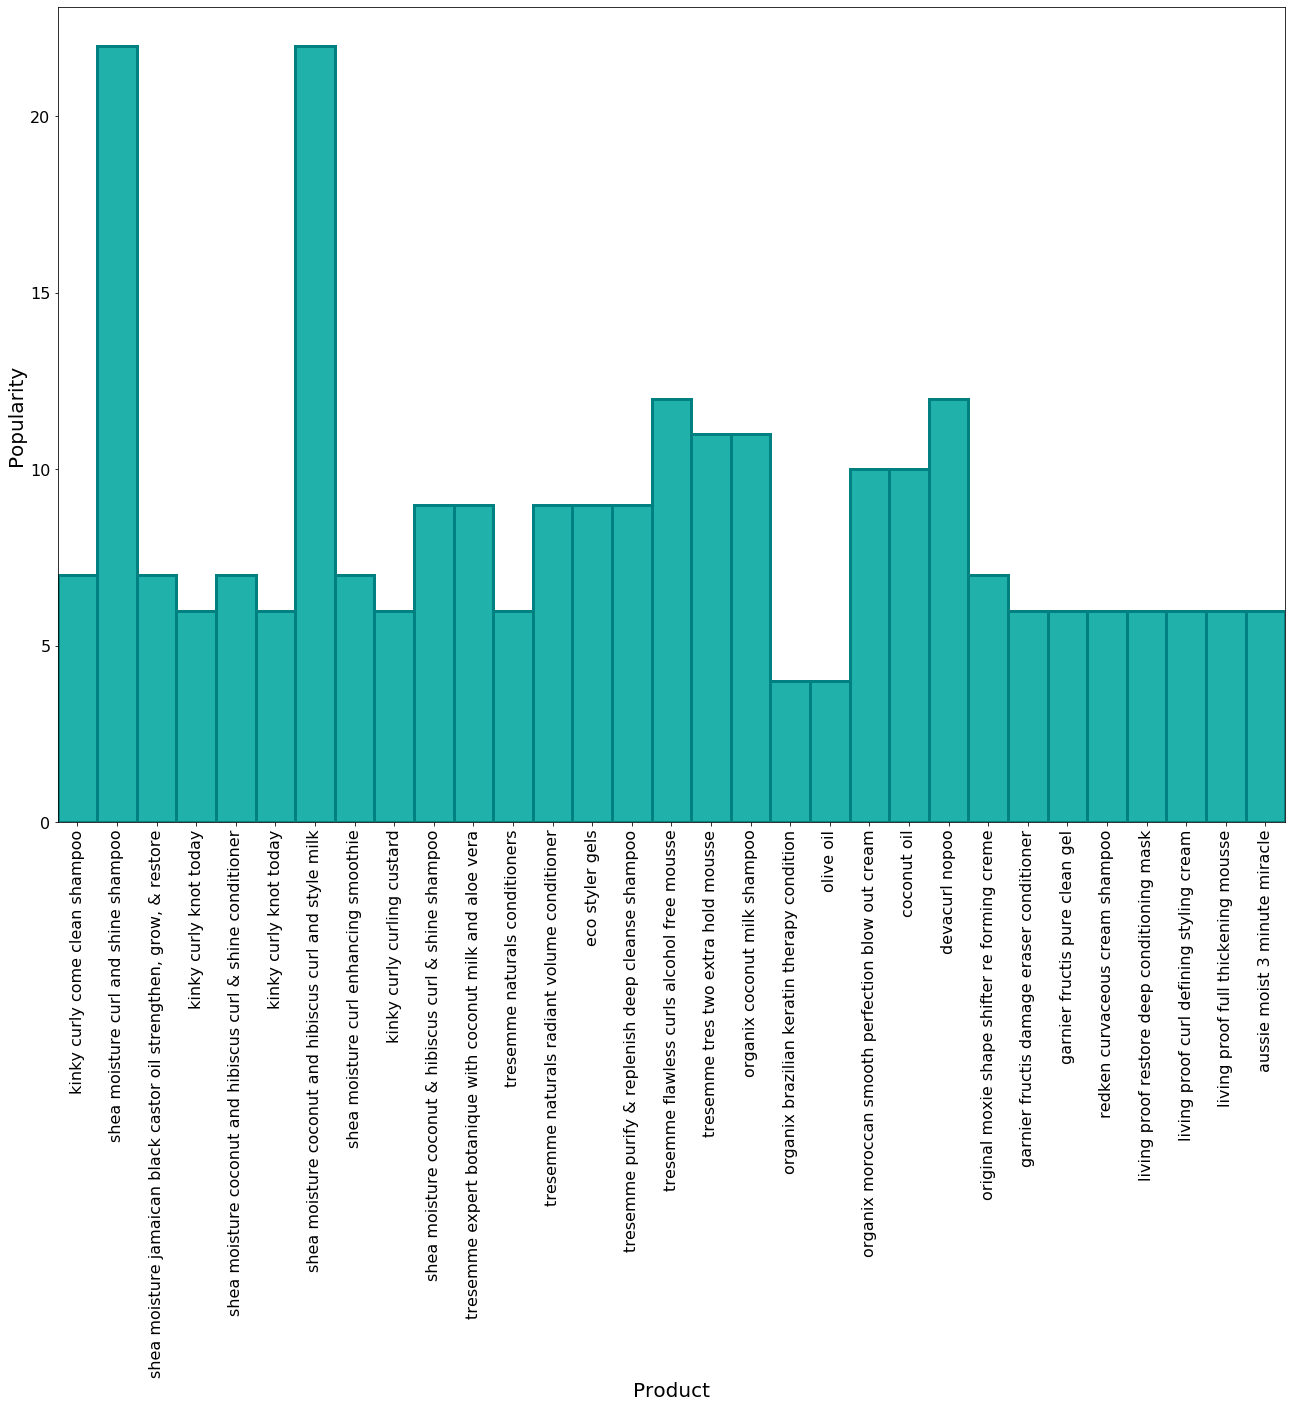

In [94]:
labels, values = zip(*Counter(full_list_tup).items())
values = [x for x in values if x > 3]
labels = [labels[i][0] for i, x in enumerate(values) if x >3]

indexes = np.arange(len(labels))
width = 1

plt.figure(figsize=(22,15))
plt.bar(indexes, values, width, color='lightseagreen', edgecolor='teal', linewidth=3)
plt.xticks(indexes, labels, rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Product', fontsize=20)
plt.xlim(-0.5,30.5)
plt.ylabel('Popularity', fontsize=20)
plt.savefig('hist.png')

In [124]:
df = pd.DataFrame(full_list_tup, columns=['product', 'type'])
df.head()

,product,type
0,kinky curly come clean shampoo,shampoo
1,shea moisture curl and shine shampoo,shampoo
2,shea moisture jamaican black castor oil streng...,shampoo
3,kinky curly knot today,conditioner
4,shea moisture coconut and hibiscus curl & shin...,conditioner


In [138]:
(df.groupby('type')['product'].apply(lambda x: x.mode().iat[0]))


type
clarifying shampoo     tresemme purify & replenish deep cleanse shampoo
conditioner                   garnier fructis damage eraser conditioner
cream                             shea moisture curl enhancing smoothie
deep treatment                                                argan oil
gel                                      garnier fructis pure clean gel
leave in                                 tresemme naturals conditioners
mousse                      tresemme flawless curls alcohol free mousse
protein               aphogee intensive two minute keratin reconstru...
serum                                           giovanni la hold spritz
shampoo                            shea moisture curl and shine shampoo
Name: product, dtype: object

In [132]:
df['product'].iloc[0]

'kinky curly come clean shampoo'